In [1]:
!pip install roboflow

  Obtaining dependency information for roboflow from https://files.pythonhosted.org/packages/33/5d/0b0b6a9e5e62cb79dd86c335a6c7f25e8f204d2f724496af0cba08058306/roboflow-1.1.9-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.4 MB/s eta 0:00:00
  Obtaining dependency information for opencv-python-headless==4.8.0.74 from https://files.pythonhosted.org/packages/76/02/f128517f3ade4bb5f71e2afd8461dba70e3f466ce745fa1fd1fade9ad1b7/opencv_python_headless-4.8.0.74-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 6.0 MB/s eta 0:00:00
  Obtaining dependency information for supervision from https://files.pythonhosted.org/packages/c0/59/6bc863f530c0ba5da4c565fd40f17b2b333c2ab28b783202937293ae494a/supervision-0.16.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 6.2 MB/s et

##  Dataset

In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("mike-caulfild").project("chtozalevetottigr")
dataset = project.version(4).download("folder")

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ChtoZaLevEtotTigr-4 in folder:: 100%|██████████| 4255/4255 [00:00<00:00, 6208.94it/s]


In [80]:
import torch
from torch import nn
from torchvision import transforms, datasets
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from tqdm import tqdm
import numpy as np
import os

Из обучающих данных высчитываем значения для нормализации изображений:

In [81]:
train_dataset = datasets.ImageFolder(
    root = '/kaggle/working/ChtoZaLevEtotTigr-4/train', 
    transform=transforms.Compose([
        transforms.Resize((224,224)),  
        transforms.ToTensor(),
    ])
)

train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=False, num_workers=2, pin_memory=True)

means = []
stdevs = []
for X, _ in train_dataloader:
    # Dimensions 0,2,3 are respectively the batch, height and width dimensions
    means.append(X.mean(dim=(0,2,3)))
    stdevs.append(X.std(dim=(0,2,3)))

mean = torch.stack(means, dim=0).mean(dim=0)
stdev = torch.stack(stdevs, dim=0).mean(dim=0)

Подготавливаем обучающую и валидационную выборки

In [196]:
train_transforms = transforms.Compose([
        transforms.RandomRotation(degrees = (-30, 30)),
#         transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
#         transforms.RandomAffine(degrees=(-30, 30), translate=(0.1, 0.3), scale=(0.6, 0.8)),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, stdev)
        ])

train_dataset = torchvision.datasets.ImageFolder("/kaggle/working/ChtoZaLevEtotTigr-4/train", transform=train_transforms)


valid_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, stdev)
    ])

valid_dataset = datasets.ImageFolder("/kaggle/working/ChtoZaLevEtotTigr-4/valid", transform=valid_transforms)

num_gpus = torch.cuda.device_count()

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2*num_gpus, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=256, shuffle=False, num_workers=2*num_gpus, pin_memory=True)

## Training

In [197]:
import matplotlib.pyplot as plt


class Model(nn.Module):
    def __init__(self, num_classes = 4):
        super().__init__()
        self.resnet = resnet18(weights = ResNet18_Weights.DEFAULT)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        return self.resnet(x)
    
    def predict(self, x):
        x = self.resnet(x)
        x = nn.functional.softmax(x, dim = 1)
        logit, idx = torch.max(x, dim = 1)
        return idx, logit
      
def train(model, train_dataloader, valid_dataloader, criterion, optimizer, scheduler=None, epochs=10, device='cpu', checkpoint_epochs=10):
    
    global train_losses,val_losses, f1_scores
    best_f1 = 0
    start = time.time()
    print(f'Training for {epochs} epochs on {device}')
    for epoch in range(1,epochs+1):
        print(f"Epoch {epoch}/{epochs}")
        
        model.train()
        train_loss = torch.tensor(0., device=device) 
        train_bar = tqdm(train_dataloader, total=len(train_dataloader))
        for step, batch in enumerate(train_bar):
            images = batch[0].to(device)
            labels = batch[1].to(device)
            preds = model(images)
            loss = criterion(preds, labels)
            train_bar.set_description("epoch {} loss {}".format(epoch,loss))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                train_loss += loss * train_dataloader.batch_size
        
        if valid_dataloader is not None:
            logits = []
            y_trues = []
            y_preds = []
            model.eval() 
            valid_loss = torch.tensor(0., device=device)
            val_bar = tqdm(valid_dataloader,total=len(valid_dataloader))
            for step, batch in enumerate(val_bar):
                with torch.no_grad():
                    images = batch[0].to(device)
                    labels = batch[1].to(device)
                    preds = model(images)
                    loss = criterion(preds, labels)
                    
                    valid_loss += loss * valid_dataloader.batch_size
                    y_preds.append(torch.argmax(preds, dim=1).cpu().numpy())
                    y_trues.append(labels.cpu().numpy())
                    
            y_trues = np.concatenate(y_trues,0)
            y_preds = np.concatenate(y_preds,0)
            train_loss = train_loss/len(train_dataloader.dataset)
            valid_loss = valid_loss/len(valid_dataloader.dataset)
            
            precision = precision_score(y_trues, y_preds, average = "weighted")
            recall = recall_score(y_trues, y_preds, average = "weighted")
            f1 = f1_score(y_trues, y_preds, average = "weighted")
            result = {
            "eval_recall": float(recall),
            "eval_precision": float(precision),
            "eval_f1": float(f1),
            "eval_loss": float(valid_loss)
            }
            
            train_losses.append(float(train_loss))
            val_losses.append(float(valid_loss))
            f1_scores.append(float(f1))
            
        if scheduler is not None: 
            scheduler.step()
        
        if valid_dataloader is not None:
            print("***** Eval results *****")
            for key in  sorted(result.keys()):
                print(key, str(round(result[key],4)))
            if result['eval_f1']>best_f1:
                best_f1=result['eval_f1']
                print("  "+"*"*20)
                print("  Best f1:",round(best_f1,4))
                print("  "+"*"*20)
                torch.save({
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, './model_best_f1.pth.tar')
                print(f"model saved: {os.getcwd()}/model_best_f1.pth.tar")
                
    end = time.time()
    print(f'Total training time: {end-start:.1f} seconds')

In [208]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 2e-6
weight_decay = 5e-4
epochs = 70

model = Model().to(device)

# Standard CrossEntropy Loss for multi-class classification problems
criterion = nn.CrossEntropyLoss()

# params_1x are the parameters of the network body, i.e., of all layers except the FC layers
params_1x = [param for name, param in model.named_parameters() if 'fc' not in str(name)]
optimizer = torch.optim.Adam([{'params':params_1x}, 
                              {'params': model.resnet.fc.parameters(), 'lr': lr*100}], 
                             lr=lr, weight_decay=weight_decay)

train_losses = []
val_losses = []
f1_scores = []

train(model, train_dataloader, valid_dataloader, criterion, optimizer, None, epochs, device)

Training for 70 epochs on cuda
Epoch 1/70


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


***** Eval results *****
eval_f1 0.3439
eval_loss 1.3206
eval_precision 0.4623
eval_recall 0.3874
  ********************
  Best f1: 0.3439
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 2/70


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


***** Eval results *****
eval_f1 0.4967
eval_loss 1.1916
eval_precision 0.5582
eval_recall 0.5013
  ********************
  Best f1: 0.4967
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 3/70


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


***** Eval results *****
eval_f1 0.5707
eval_loss 1.0759
eval_precision 0.5968
eval_recall 0.5841
  ********************
  Best f1: 0.5707
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 4/70


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


***** Eval results *****
eval_f1 0.6424
eval_loss 0.9919
eval_precision 0.6755
eval_recall 0.6452
  ********************
  Best f1: 0.6424
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 5/70


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


***** Eval results *****
eval_f1 0.6913
eval_loss 0.9096
eval_precision 0.7004
eval_recall 0.6921
  ********************
  Best f1: 0.6913
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 6/70


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


***** Eval results *****
eval_f1 0.7276
eval_loss 0.841
eval_precision 0.729
eval_recall 0.7297
  ********************
  Best f1: 0.7276
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 7/70


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


***** Eval results *****
eval_f1 0.7491
eval_loss 0.7749
eval_precision 0.7512
eval_recall 0.7515
  ********************
  Best f1: 0.7491
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 8/70


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


***** Eval results *****
eval_f1 0.7652
eval_loss 0.7237
eval_precision 0.7694
eval_recall 0.7674
  ********************
  Best f1: 0.7652
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 9/70


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


***** Eval results *****
eval_f1 0.7903
eval_loss 0.6743
eval_precision 0.7896
eval_recall 0.7916
  ********************
  Best f1: 0.7903
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 10/70


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


***** Eval results *****
eval_f1 0.8069
eval_loss 0.6338
eval_precision 0.8074
eval_recall 0.8067
  ********************
  Best f1: 0.8069
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 11/70


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


***** Eval results *****
eval_f1 0.8144
eval_loss 0.5935
eval_precision 0.8136
eval_recall 0.8167
  ********************
  Best f1: 0.8144
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 12/70


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


***** Eval results *****
eval_f1 0.8275
eval_loss 0.5599
eval_precision 0.8267
eval_recall 0.8285
  ********************
  Best f1: 0.8275
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 13/70


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


***** Eval results *****
eval_f1 0.837
eval_loss 0.5349
eval_precision 0.8378
eval_recall 0.8368
  ********************
  Best f1: 0.837
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 14/70


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


***** Eval results *****
eval_f1 0.8405
eval_loss 0.5117
eval_precision 0.841
eval_recall 0.8402
  ********************
  Best f1: 0.8405
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 15/70


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


***** Eval results *****
eval_f1 0.8452
eval_loss 0.4924
eval_precision 0.8466
eval_recall 0.8444
  ********************
  Best f1: 0.8452
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 16/70


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


***** Eval results *****
eval_f1 0.8453
eval_loss 0.4748
eval_precision 0.8465
eval_recall 0.8444
  ********************
  Best f1: 0.8453
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 17/70


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


***** Eval results *****
eval_f1 0.8455
eval_loss 0.4569
eval_precision 0.8458
eval_recall 0.8452
  ********************
  Best f1: 0.8455
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 18/70


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


***** Eval results *****
eval_f1 0.8507
eval_loss 0.4453
eval_precision 0.8512
eval_recall 0.8502
  ********************
  Best f1: 0.8507
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 19/70


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


***** Eval results *****
eval_f1 0.855
eval_loss 0.4344
eval_precision 0.8568
eval_recall 0.8536
  ********************
  Best f1: 0.855
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 20/70


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


***** Eval results *****
eval_f1 0.854
eval_loss 0.425
eval_precision 0.8556
eval_recall 0.8527
Epoch 21/70


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


***** Eval results *****
eval_f1 0.8553
eval_loss 0.4135
eval_precision 0.8564
eval_recall 0.8544
  ********************
  Best f1: 0.8553
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 22/70


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


***** Eval results *****
eval_f1 0.8562
eval_loss 0.41
eval_precision 0.8587
eval_recall 0.8544
  ********************
  Best f1: 0.8562
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 23/70


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


***** Eval results *****
eval_f1 0.8584
eval_loss 0.4023
eval_precision 0.8607
eval_recall 0.8569
  ********************
  Best f1: 0.8584
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 24/70


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


***** Eval results *****
eval_f1 0.8565
eval_loss 0.397
eval_precision 0.8605
eval_recall 0.8544
Epoch 25/70


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


***** Eval results *****
eval_f1 0.8586
eval_loss 0.396
eval_precision 0.8626
eval_recall 0.8561
  ********************
  Best f1: 0.8586
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 26/70


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


***** Eval results *****
eval_f1 0.8612
eval_loss 0.3799
eval_precision 0.8615
eval_recall 0.8611
  ********************
  Best f1: 0.8612
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 27/70


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


***** Eval results *****
eval_f1 0.8617
eval_loss 0.3782
eval_precision 0.864
eval_recall 0.8603
  ********************
  Best f1: 0.8617
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 28/70


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


***** Eval results *****
eval_f1 0.8626
eval_loss 0.3793
eval_precision 0.8668
eval_recall 0.8603
  ********************
  Best f1: 0.8626
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 29/70


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


***** Eval results *****
eval_f1 0.8638
eval_loss 0.3703
eval_precision 0.8664
eval_recall 0.8628
  ********************
  Best f1: 0.8638
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 30/70


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


***** Eval results *****
eval_f1 0.8624
eval_loss 0.3772
eval_precision 0.8677
eval_recall 0.8594
Epoch 31/70


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


***** Eval results *****
eval_f1 0.8687
eval_loss 0.3636
eval_precision 0.8701
eval_recall 0.8678
  ********************
  Best f1: 0.8687
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 32/70


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


***** Eval results *****
eval_f1 0.8641
eval_loss 0.365
eval_precision 0.8679
eval_recall 0.8619
Epoch 33/70


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


***** Eval results *****
eval_f1 0.8654
eval_loss 0.3672
eval_precision 0.8696
eval_recall 0.8628
Epoch 34/70


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


***** Eval results *****
eval_f1 0.8657
eval_loss 0.36
eval_precision 0.869
eval_recall 0.8636
Epoch 35/70


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


***** Eval results *****
eval_f1 0.8665
eval_loss 0.3634
eval_precision 0.8714
eval_recall 0.8636
Epoch 36/70


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


***** Eval results *****
eval_f1 0.8705
eval_loss 0.3592
eval_precision 0.8754
eval_recall 0.8678
  ********************
  Best f1: 0.8705
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 37/70


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


***** Eval results *****
eval_f1 0.8697
eval_loss 0.3535
eval_precision 0.8726
eval_recall 0.8678
Epoch 38/70


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


***** Eval results *****
eval_f1 0.8739
eval_loss 0.3511
eval_precision 0.8774
eval_recall 0.872
  ********************
  Best f1: 0.8739
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 39/70


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


***** Eval results *****
eval_f1 0.8712
eval_loss 0.3578
eval_precision 0.8755
eval_recall 0.8686
Epoch 40/70


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


***** Eval results *****
eval_f1 0.8748
eval_loss 0.3497
eval_precision 0.8781
eval_recall 0.8728
  ********************
  Best f1: 0.8748
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 41/70


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


***** Eval results *****
eval_f1 0.8743
eval_loss 0.3509
eval_precision 0.8781
eval_recall 0.872
Epoch 42/70


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


***** Eval results *****
eval_f1 0.8745
eval_loss 0.3453
eval_precision 0.8776
eval_recall 0.8728
Epoch 43/70


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


***** Eval results *****
eval_f1 0.8751
eval_loss 0.3544
eval_precision 0.881
eval_recall 0.872
  ********************
  Best f1: 0.8751
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 44/70


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


***** Eval results *****
eval_f1 0.8747
eval_loss 0.3506
eval_precision 0.8795
eval_recall 0.872
Epoch 45/70


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


***** Eval results *****
eval_f1 0.8736
eval_loss 0.3416
eval_precision 0.8769
eval_recall 0.872
Epoch 46/70


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


***** Eval results *****
eval_f1 0.8744
eval_loss 0.3492
eval_precision 0.8787
eval_recall 0.872
Epoch 47/70


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


***** Eval results *****
eval_f1 0.8754
eval_loss 0.3411
eval_precision 0.879
eval_recall 0.8736
  ********************
  Best f1: 0.8754
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 48/70


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


***** Eval results *****
eval_f1 0.8809
eval_loss 0.3449
eval_precision 0.8844
eval_recall 0.8787
  ********************
  Best f1: 0.8809
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 49/70


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


***** Eval results *****
eval_f1 0.8751
eval_loss 0.3458
eval_precision 0.8793
eval_recall 0.8728
Epoch 50/70


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


***** Eval results *****
eval_f1 0.8795
eval_loss 0.3411
eval_precision 0.8826
eval_recall 0.8778
Epoch 51/70


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


***** Eval results *****
eval_f1 0.8746
eval_loss 0.3501
eval_precision 0.8795
eval_recall 0.872
Epoch 52/70


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


***** Eval results *****
eval_f1 0.8806
eval_loss 0.3436
eval_precision 0.8838
eval_recall 0.8787
Epoch 53/70


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


***** Eval results *****
eval_f1 0.8767
eval_loss 0.3425
eval_precision 0.8807
eval_recall 0.8745
Epoch 54/70


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


***** Eval results *****
eval_f1 0.8788
eval_loss 0.3399
eval_precision 0.8822
eval_recall 0.877
Epoch 55/70


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


***** Eval results *****
eval_f1 0.8803
eval_loss 0.3397
eval_precision 0.8833
eval_recall 0.8787
Epoch 56/70


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


***** Eval results *****
eval_f1 0.8803
eval_loss 0.3495
eval_precision 0.8847
eval_recall 0.8778
Epoch 57/70


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


***** Eval results *****
eval_f1 0.8805
eval_loss 0.3426
eval_precision 0.8837
eval_recall 0.8787
Epoch 58/70


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


***** Eval results *****
eval_f1 0.8817
eval_loss 0.3456
eval_precision 0.8853
eval_recall 0.8795
  ********************
  Best f1: 0.8817
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 59/70


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


***** Eval results *****
eval_f1 0.8799
eval_loss 0.3441
eval_precision 0.8834
eval_recall 0.8778
Epoch 60/70


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


***** Eval results *****
eval_f1 0.8815
eval_loss 0.3463
eval_precision 0.8848
eval_recall 0.8795
Epoch 61/70


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


***** Eval results *****
eval_f1 0.8832
eval_loss 0.3467
eval_precision 0.8865
eval_recall 0.8812
  ********************
  Best f1: 0.8832
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 62/70


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


***** Eval results *****
eval_f1 0.882
eval_loss 0.3427
eval_precision 0.8847
eval_recall 0.8803
Epoch 63/70


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


***** Eval results *****
eval_f1 0.881
eval_loss 0.348
eval_precision 0.885
eval_recall 0.8787
Epoch 64/70


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


***** Eval results *****
eval_f1 0.8842
eval_loss 0.3476
eval_precision 0.8879
eval_recall 0.882
  ********************
  Best f1: 0.8842
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 65/70


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


***** Eval results *****
eval_f1 0.8835
eval_loss 0.3508
eval_precision 0.8875
eval_recall 0.8812
Epoch 66/70


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


***** Eval results *****
eval_f1 0.8853
eval_loss 0.3409
eval_precision 0.8878
eval_recall 0.8837
  ********************
  Best f1: 0.8853
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 67/70


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


***** Eval results *****
eval_f1 0.8872
eval_loss 0.3449
eval_precision 0.8901
eval_recall 0.8854
  ********************
  Best f1: 0.8872
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 68/70


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


***** Eval results *****
eval_f1 0.8867
eval_loss 0.3381
eval_precision 0.8888
eval_recall 0.8854
Epoch 69/70


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


***** Eval results *****
eval_f1 0.8878
eval_loss 0.3435
eval_precision 0.8901
eval_recall 0.8862
  ********************
  Best f1: 0.8878
  ********************
model saved: /kaggle/working/model_best_f1.pth
Epoch 70/70


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


***** Eval results *****
eval_f1 0.8879
eval_loss 0.3435
eval_precision 0.8906
eval_recall 0.8862
  ********************
  Best f1: 0.8879
  ********************
model saved: /kaggle/working/model_best_f1.pth
Total training time: 920.2 seconds


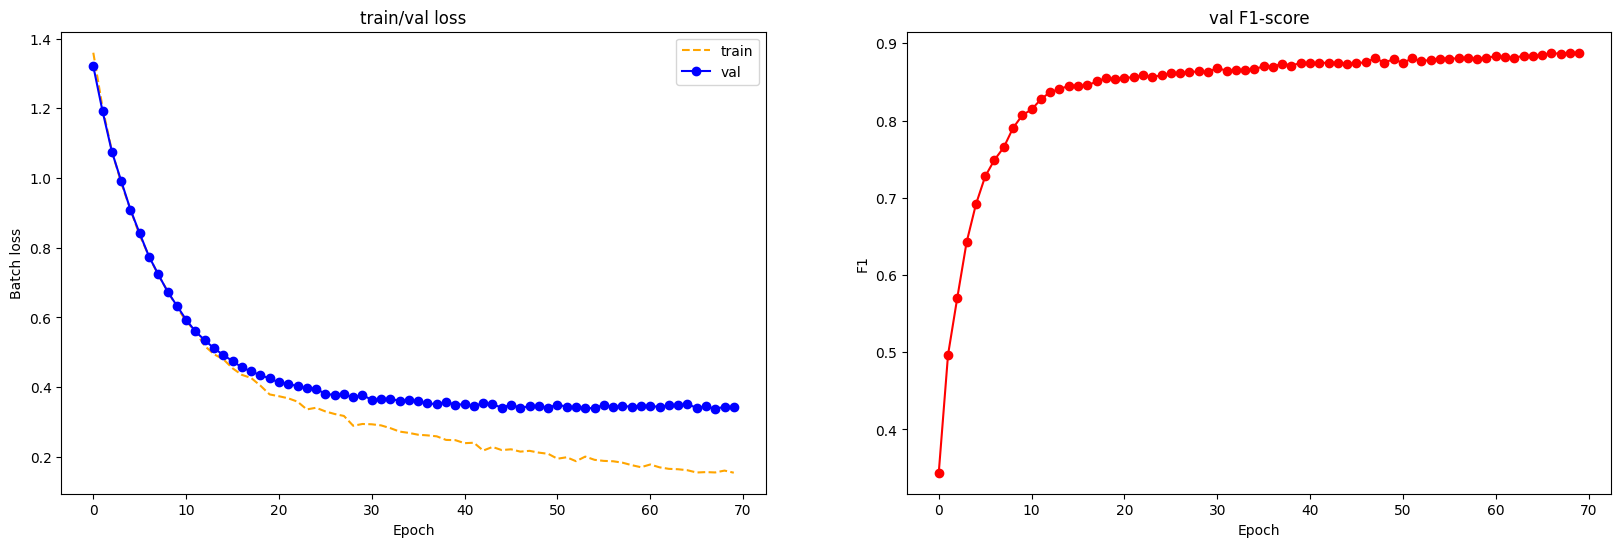

In [209]:
def plot_results(Loss_train, Loss_val, f1_scores):
    fig, axs = plt.subplots(1, 2, figsize=(20, 6)) 
    
    axs[0].plot(range(len(Loss_train)), Loss_train, color='orange', label='train', linestyle='--')
    axs[0].plot(range(len(Loss_val)), Loss_val, color='blue', marker='o', label='val')
    axs[0].set_title('train/val loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Batch loss')
    axs[0].legend()
    
    axs[1].plot(range(len(f1_scores)), f1_scores, color='red', marker='o')
    axs[1].set_title('val F1-score')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('F1')
    
    plt.show()

plot_results(train_losses, val_losses, f1_scores)

## Test

In [212]:
model_path = "/kaggle/working/model_best_f1.pth.tar"
checkpoint = torch.load(model_path)
net = Model()
net.load_state_dict(checkpoint["state_dict"])
net.eval()

Model(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

front 0.8498146533966064


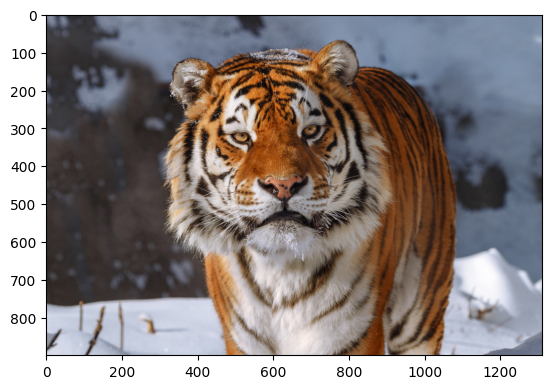

In [213]:
import urllib.request
from PIL import Image
import matplotlib.pyplot as plt

image_url = 'https://rgo.ru/upload/s34web.imageadapter/3391b95c081666cc16ceb5b195d7ccf4/oleg_bogdanov_amurskiy_tigr_592345.jpg'
urllib.request.urlretrieve(image_url,"image.png")
image = Image.open("image.png")
plt.imshow(image)

CLASSES = valid_dataset.classes
image = valid_transforms(image).unsqueeze(0)
result, conf = net.predict(image)
print(CLASSES[result], float(conf))


